In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define folder path
folder_path = '/content/drive/My Drive/Colab Notebooks/projects/UNET_PL_Prediction/data'

# List all Excel files in the folder
file_names = os.listdir(folder_path)
#excel_files = [file for file in file_names if file.endswith('.xlsx')]
csv_files = [file for file in file_names if file.endswith('.csv')]
result_df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    result_df = pd.concat([result_df, df])
result_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transmitter_ZZ,8201250.0,35.000000,8.164966,25.000000,25.000000,35.000000,45.000000,45.000000
no_visible_walls,8201250.0,19.990535,12.430751,1.000000,11.000000,17.000000,26.000000,56.000000
Phi,8201250.0,11.611903,9.363284,2.392370,6.069790,8.753930,13.493000,89.913000
indoor_distance,8201250.0,68.205393,53.318614,0.000000,29.217900,61.198900,99.652900,390.627000
2d_distance,8201250.0,224.594638,108.728140,0.068041,141.912800,215.231950,298.213200,562.499000
3d_distance,8201250.0,228.233804,106.596469,23.500100,146.042000,217.986000,300.206000,564.179000
avg_wall_height,8201250.0,17.092503,6.625684,0.000000,17.714300,19.500000,20.750000,24.000000
is_building,8201250.0,0.382721,0.486051,0.000000,0.000000,0.000000,1.000000,1.000000
Path_loss,8201250.0,118.274244,12.164306,90.135625,109.053834,113.746736,131.202709,140.170147


In [ ]:
stats_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/projects/UNET_PL_Prediction/data/stats.csv', index_col=0)
GLOBAL_MIN_PATH_LOSS = stats_df.loc['Path_loss']['min']
GLOBAL_MAX_PATH_LOSS = stats_df.loc['Path_loss']['max']
GLOBAL_MIN_AVG_WALL_HEIGHT = stats_df.loc['avg_wall_height']['min']
GLOBAL_MAX_AVG_WALL_HEIGHT = stats_df.loc['avg_wall_height']['max']
GLOBAL_MIN_3D_DISTANCE = stats_df.loc['3d_distance']['min']
GLOBAL_MAX_3D_DISTANCE = stats_df.loc['3d_distance']['max']
GLOBAL_MIN_2D_DISTANCE = stats_df.loc['2d_distance']['min']
GLOBAL_MAX_2D_DISTANCE = stats_df.loc['2d_distance']['max']
GLOBAL_MIN_INDOOR_DISTANCE = stats_df.loc['indoor_distance']['min']
GLOBAL_MAX_INDOOR_DISTANCE = stats_df.loc['indoor_distance']['max']
GLOBAL_MIN_PHI = stats_df.loc['Phi']['min']
GLOBAL_MAX_PHI = stats_df.loc['Phi']['max']
GLOBAL_MIN_NO_VISIBLE_WALLS = stats_df.loc['no_visible_walls']['min']
GLOBAL_MAX_NO_VISIBLE_WALLS = stats_df.loc['no_visible_walls']['max']

In [ ]:
print(GLOBAL_MIN_PATH_LOSS)
print(GLOBAL_MAX_PATH_LOSS)
print(GLOBAL_MIN_AVG_WALL_HEIGHT)
print(GLOBAL_MAX_AVG_WALL_HEIGHT)
print(GLOBAL_MIN_3D_DISTANCE)
print(GLOBAL_MAX_3D_DISTANCE)
print(GLOBAL_MIN_2D_DISTANCE)
print(GLOBAL_MAX_2D_DISTANCE)
print(GLOBAL_MIN_INDOOR_DISTANCE)
print(GLOBAL_MAX_INDOOR_DISTANCE)
print(GLOBAL_MIN_PHI)
print(GLOBAL_MAX_PHI)
print(GLOBAL_MIN_NO_VISIBLE_WALLS)
print(GLOBAL_MAX_NO_VISIBLE_WALLS)

90.1356245437624
140.17014741969638
0.0
24.0
23.5001
564.179
0.0680413
562.499
0.0
390.627
2.39237
89.913
1.0
56.0


## 1. Dataset Preparation


### Path Loss Modeling using ITU-R/3GPP Models

In [ ]:
def compute_empirical_pathloss(row):

    h = row['Transmitter_ZZ']
    d = row['3d_distance']
    d2 = row['2d_distance']

    d_bp = 4 * (h - 1) * 0.5 * (28000000000 / 300000000)

    PL1 = 32.4 + 21 * np.log10(d) + 20 * np.log10(28)  # 3GPP

    PL = np.where(d2 > d_bp,
                  32.4 + 40 * np.log10(d) + 20 * np.log10(28) - 9.5 * np.log10((d_bp * d_bp) + ((h - 1.5) ** 2)),
                  PL1)

    return PL

In [ ]:
def compute_is_building(row):
    if row['is_not_building'] == 0:
        return 1
    else:
        return 0

In [ ]:
from scipy.stats import norm

# Function to calculate BEL (Building Entry Loss)
def calc_BEL(row):
    frequency = 28
    probability = 0.5
    Phi = row['Phi']
    r, s, t = 12.64, 3.72, 0.96  # Coefficients for L_h

    u, v = 9.6, 2.0              # σ1 and μ2 parameters
    w, x = 9.1, -3.0             # σ1 and μ2 parameters

    y, z = 9.4, -2.1             # σ2 parameters

    C = -3.0                     # Constant for BEL calculation
    F_inv_p = norm.ppf(probability)  # Calculate F^-1(P)

    # Calculate median horizontal path loss and elevation angle correction
    L_h = r + s * np.log10(frequency) + t * (np.log10(frequency))**2
    L_e = 0.212 * abs(Phi)

    # Calculate μ1 and μ2
    mu_1 = L_h + L_e
    mu_2 = w + x * np.log10(frequency)

    # Calculate σ1 and σ2
    sigma_1 = u + v * np.log10(frequency)
    sigma_2 = y + z * np.log10(frequency)

    # Calculate A(P) and B(P)
    A_P = F_inv_p * sigma_1 + mu_1
    B_P = F_inv_p * sigma_2 + mu_2

    # Calculate BEL using the given formula
    BEL = 10 * np.log10(10**(0.1 * A_P) + 10**(0.1 * B_P) + 10**(0.1 * C))

    return BEL

In [ ]:
GLOBAL_MIN_PATHLOSS = 1000
GLOBAL_MAX_PATHLOSS = -1000

In [ ]:
# Read and process each Excel file
count = 1
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    data = pd.read_excel(file_path)
    data.columns = ['index_rx', 'Receiver_XX', 'Receiver_YY', 'Transmitter_XX', 'Transmitter_YY', 'Transmitter_ZZ', 'no_visible_walls', 'avg_distance_to_walls', 'min_distance_to_walls', 'Phi', 'Theta', '3d_distance', 'walls_pen', 'indoor_distance', 'outdoor_distance', 'min_wall_height', 'max_wall_height', 'avg_wall_height', 'is_not_building', 'Path_loss']
    data['2d_distance'] = data['indoor_distance'] + data['outdoor_distance']
    data['is_building'] = data.apply(compute_is_building, axis=1)
    data['emp_path_loss'] = data.apply(compute_empirical_pathloss, axis=1).astype(float)
    data['bel_loss'] = data.apply(calc_BEL, axis=1).astype(float)
    data['bel_plus_path_loss'] = data['bel_loss'] + data['emp_path_loss']
    data.loc[data['is_building'] == 1, 'Path_loss'] = data['bel_plus_path_loss']
    data.loc[data['is_building'] == 0, 'Path_loss'] = data['emp_path_loss']
    cols = ['Transmitter_ZZ', 'no_visible_walls', 'Phi', 'indoor_distance','2d_distance', '3d_distance', 'avg_wall_height', 'is_building', 'Path_loss']
    data = data[cols]
    data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
    data['Path_loss'] = data['Path_loss'].astype(float)
    if data['Path_loss'].min() < GLOBAL_MIN_PATHLOSS:
        GLOBAL_MIN_PATHLOSS = data['Path_loss'].min()
    if data['Path_loss'].max() > GLOBAL_MAX_PATHLOSS:
        GLOBAL_MAX_PATHLOSS = data['Path_loss'].max()
    csv_path = file_path[:-4] + 'csv'
    data.to_csv(csv_path, index=False)
    del data
    print(f"Processed {file}")
    print(f"Processed {count} files out of {len(excel_files)}")
    print()
    count = count + 1

<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_01a.xlsx
Processed 1 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_01b.xlsx
Processed 2 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_01c.xlsx
Processed 3 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_02a.xlsx
Processed 4 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_02b.xlsx
Processed 5 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_02c.xlsx
Processed 6 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_03a.xlsx
Processed 7 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_03b.xlsx
Processed 8 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_03c.xlsx
Processed 9 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_04a.xlsx
Processed 10 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_04b.xlsx
Processed 11 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich01_tx_loc_04c.xlsx
Processed 12 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_01a.xlsx
Processed 13 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_01b.xlsx
Processed 14 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_01c.xlsx
Processed 15 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_02a.xlsx
Processed 16 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_02b.xlsx
Processed 17 files out of 18



<ipython-input-9-a2cdd96dd311>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transmitter_ZZ'] = data['Transmitter_ZZ'].astype(float)
<ipython-input-9-a2cdd96dd311>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Path_loss'] = data['Path_loss'].astype(float)


Processed path_loss_hd_dataset_munich02_tx_loc_02c.xlsx
Processed 18 files out of 18



In [ ]:
print(GLOBAL_MIN_PATHLOSS)
print(GLOBAL_MAX_PATHLOSS)

90.1356245437624
140.17014741969638


### Custom Dataset Class

In [ ]:
class UAVChannelDataset:
    def __init__(self, directory,global_mins, global_maxs, feature_cols=['3d_distance', 'Phi', 'is_building'], target_col='Path_loss', training=True):
        self.training = training
        self.train_directory = os.path.join(directory, 'train')
        self.test_directory = os.path.join(directory, 'test')
        self.train_files = [file for file in os.listdir(self.train_directory) if file.endswith('.csv')]
        self.test_files = [file for file in os.listdir(self.test_directory) if file.endswith('.csv')]
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.global_mins = global_mins
        self.global_maxs = global_maxs  # Set this to the actual maximum path loss

    def _create_3_channel_input(self):
        files = self.train_files if self.training else self.test_files
        directory = self.train_directory if self.training else self.test_directory
        input_channels_data = []
        output_channel_data = []

        for file in files:
            total_images = 50
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path)

            # Create 3-channel input and target array
            array = np.stack([
                data[self.feature_cols[0]].values.reshape(675, 675).astype(np.float32),
                data[self.feature_cols[1]].values.reshape(675, 675).astype(np.float32),
                data[self.feature_cols[2]].values.reshape(675, 675).astype(np.float32)
            ], axis=-1)

            target = data[self.target_col].values.reshape(675, 675).astype(np.float32)
            target_norm = (target - self.global_mins[-1]) / (self.global_maxs[-1] - self.global_mins[-1])

            # Normalize each channel independently
            for i in range(3):
                channel = array[:, :, i]
                array[:, :, i] = (channel - self.global_mins[i]) / (self.global_maxs[i] - self.global_mins[i])

            used_combinations = set()

            # Step 1: Generate one image with step size 3
            step = 3
            sampled_size = 672
            x_start = 0
            y_start = 0
            sampled_image = array[x_start:x_start + sampled_size:step, y_start:y_start + sampled_size:step, :]
            sampled_output = target_norm[x_start:x_start + sampled_size:step, y_start:y_start + sampled_size:step]
            input_channels_data.append(sampled_image[:224, :224, :])
            output_channel_data.append(sampled_output[:224, :224])

            # Step 2: Generate images with step size 1
            step = 1
            for i in range(0, 675, 225):
                for j in range(0, 675, 225):
                    sampled_image = array[i:i + 225, j:j + 225, :]
                    sampled_output = target_norm[i:i + 225, j:j + 225]
                    input_channels_data.append(sampled_image[:224, :224, :])
                    output_channel_data.append(sampled_output[:224, :224])

            # Step 3: Generate images with custom step sizes
            possible_steps = [(1, 2), (2, 1), (1, 1), (2, 2), (1, 3), (3, 1), (2, 3), (3, 2)]
            counter = 10

            while counter < total_images:
                horizontal_step, vertical_step = possible_steps[np.random.randint(0, len(possible_steps))]
                sampled_size_h = 225 * horizontal_step
                sampled_size_v = 225 * vertical_step

                max_x = array.shape[0] - sampled_size_v
                max_y = array.shape[1] - sampled_size_h

                x_start = np.random.randint(0, max_x + 1)
                y_start = np.random.randint(0, max_y + 1)
                combination = (horizontal_step, vertical_step, x_start, y_start)
                if combination in used_combinations:
                    continue
                used_combinations.add(combination)
                sampled_image = array[x_start:x_start + sampled_size_v:vertical_step, y_start:y_start + sampled_size_h:horizontal_step, :]
                sampled_output = target_norm[x_start:x_start + sampled_size_v:vertical_step, y_start:y_start + sampled_size_h:horizontal_step]
                input_channels_data.append(sampled_image[:224, :224, :])
                output_channel_data.append(sampled_output[:224, :224])
                counter = counter + 1

        input_channels_data = np.array(input_channels_data, dtype=np.float32)
        output_channel_data = np.expand_dims(np.array(output_channel_data, dtype=np.float32), axis=-1)
        return input_channels_data, output_channel_data

    def get_dataset(self):
        input_data, mask = self._create_3_channel_input()
        dataset = tf.data.Dataset.from_tensor_slices((input_data, mask))
        return dataset




In [ ]:
# Create Training
global_mins = [GLOBAL_MIN_3D_DISTANCE, GLOBAL_MIN_PHI, 0.0, GLOBAL_MIN_PATH_LOSS]
global_maxs = [GLOBAL_MAX_3D_DISTANCE, GLOBAL_MAX_PHI, 1.0, GLOBAL_MAX_PATH_LOSS]
colab_directory = '/content/drive/My Drive/Colab Notebooks/projects/UNET_PL_Prediction/data'
train_dataset = UAVChannelDataset(directory=colab_directory, global_mins = global_mins, global_maxs = global_maxs).get_dataset()
print(f"Training Dataset Size: {len(train_dataset)}")

Training Dataset Size: 600


In [ ]:
def plot_input_output(input_data, output_data, title="Sample Visualization"):
    """
    Plots the input channels and output channel side by side.

    Args:
        input_data (np.ndarray): Input data of shape (224, 224, 3).
        output_data (np.ndarray): Output data of shape (224, 224).
        title (str): Title of the plot.
    """
    # Create a figure with 1 row and 4 columns
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Plot each input channel
    for i in range(3):
        axes[i].imshow(input_data[:, :, i], cmap='Greens')
        axes[i].set_title(f'Input Channel {i+1}')
        axes[i].axis('off')

    # Plot the output channel
    axes[3].imshow(output_data, cmap='Greens')
    axes[3].set_title('Output Channel (Path Loss)')
    axes[3].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

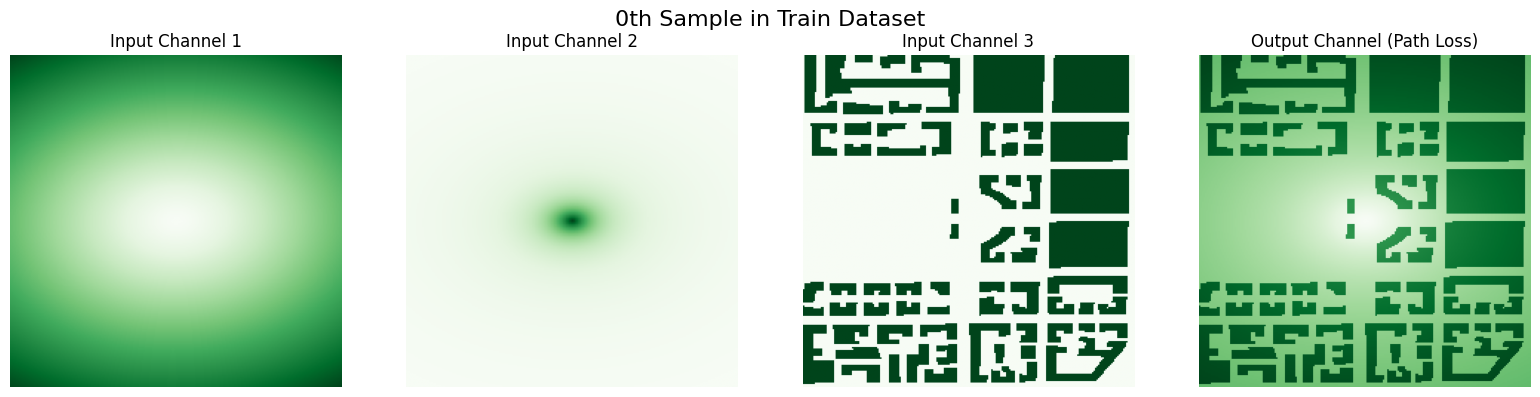

In [ ]:
# Retrieve the 3rd sample from the train dataset
for idx, (input_sample, output_sample) in enumerate(train_dataset):
    if idx == 0:  # 3rd sample (0-based index)
        # Convert TensorFlow tensors to NumPy arrays for visualization
        input_sample_np = input_sample.numpy()
        output_sample_np = output_sample.numpy().squeeze()  # Remove extra dimensions
        plot_input_output(input_sample_np, output_sample_np, title=f"{idx}th Sample in Train Dataset")
        break


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=100).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

def conv_block(inputs, num_filters, kernel_size=3, activation='relu', dropout_rate=0.3, l2_reg=1e-4):
    """
    A block consisting of two convolutional layers followed by BatchNorm and optional dropout.
    """
    x = layers.Conv2D(
        num_filters, kernel_size, activation=activation, padding='same', kernel_regularizer=l2(l2_reg)
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(
        num_filters, kernel_size, activation=activation, padding='same', kernel_regularizer=l2(l2_reg)
    )(x)
    x = layers.BatchNormalization()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

def encoder_block(inputs, num_filters, pool_size=(2, 2), dropout_rate=0.3, l2_reg=1e-4):
    """
    Encoder block: Convolutional layers followed by max pooling.
    """
    x = conv_block(inputs, num_filters, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p = layers.MaxPooling2D(pool_size)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, kernel_size=3, activation='relu', l2_reg=1e-4):
    """
    Decoder block: Upsampling followed by concatenation and convolutional layers.
    """
    x = layers.Conv2DTranspose(
        num_filters, kernel_size, strides=(2, 2), padding='same', activation=activation, kernel_regularizer=l2(l2_reg)
    )(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters, l2_reg=l2_reg)
    return x

def build_unet(input_shape=(224, 224, 3), num_filters=32, dropout_rate=0.3, l2_reg=1e-4):
    """
    Build a U-Net model for regression.
    """
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, num_filters, dropout_rate=dropout_rate, l2_reg=l2_reg)
    s2, p2 = encoder_block(p1, num_filters * 2, dropout_rate=dropout_rate, l2_reg=l2_reg)
    s3, p3 = encoder_block(p2, num_filters * 4, dropout_rate=dropout_rate, l2_reg=l2_reg)
    s4, p4 = encoder_block(p3, num_filters * 8, dropout_rate=dropout_rate, l2_reg=l2_reg)

    # Bottleneck
    b1 = conv_block(p4, num_filters * 16, dropout_rate=dropout_rate, l2_reg=l2_reg)

    # Decoder
    d1 = decoder_block(b1, s4, num_filters * 8, l2_reg=l2_reg)
    d2 = decoder_block(d1, s3, num_filters * 4, l2_reg=l2_reg)
    d3 = decoder_block(d2, s2, num_filters * 2, l2_reg=l2_reg)
    d4 = decoder_block(d3, s1, num_filters, l2_reg=l2_reg)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    # Compile the model
    model = Model(inputs, outputs, name="U-Net")
    return model

# Instantiate the model
input_shape = (224, 224, 3)  # 3-channel input
model = build_unet(input_shape=input_shape)

def my_custom_loss(y_true, y_pred):
  y_true_pl = y_true * (GLOBAL_MAX_PATH_LOSS - GLOBAL_MIN_PATH_LOSS) + GLOBAL_MIN_PATH_LOSS
  y_pred_pl = y_pred * (GLOBAL_MAX_PATH_LOSS - GLOBAL_MIN_PATH_LOSS) + GLOBAL_MIN_PATH_LOSS
  diff_squared = tf.square(y_true_pl - y_pred_pl)
  root_mean_squared = tf.sqrt(tf.reduce_mean(diff_squared))
  return root_mean_squared

def my_custom_mae(y_true, y_pred):
  y_true_pl = y_true * (GLOBAL_MAX_PATH_LOSS - GLOBAL_MIN_PATH_LOSS) + GLOBAL_MIN_PATH_LOSS
  y_pred_pl = y_pred * (GLOBAL_MAX_PATH_LOSS - GLOBAL_MIN_PATH_LOSS) + GLOBAL_MIN_PATH_LOSS
  diff = tf.abs(y_true_pl - y_pred_pl)
  return tf.reduce_mean(diff)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=my_custom_loss,
              metrics=[my_custom_mae])

# Print the model summary
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_4… │
├──────────────────────

 Total params: 8,642,273 (32.97 MB)

 Trainable params: 8,636,385 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
val_dataset = UAVChannelDataset(directory=colab_directory, global_mins = global_mins, global_maxs = global_maxs, training=False).get_dataset()
val_dataset = val_dataset.batch(1)

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - loss: 16.9104 - my_custom_mae: 13.5122 - val_loss: 11.7975 - val_my_custom_mae: 9.6407
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - loss: 9.9676 - my_custom_mae: 7.7049 - val_loss: 11.2548 - val_my_custom_mae: 9.6878
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - loss: 8.6895 - my_custom_mae: 6.7381 - val_loss: 11.0004 - val_my_custom_mae: 9.7048
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - loss: 7.7067 - my_custom_mae: 5.8747 - val_loss: 10.5082 - val_my_custom_mae: 9.4039
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - loss: 6.8911 - my_custom_mae: 5.1798 - val_loss: 10.0153 - val_my_custom_mae: 9.0264
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 572ms/step - loss: 6.1022 - my_custom_mae: 4.5064 - val_loss: 9.4594 - val_my_custom_mae: 8.5506
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 547ms/step - loss: 5.4153 - my_custom_mae: 3.9527 - val_loss: 9.0970 - val_my_custom_mae: 8.2216
Epoch 8/50
19/19 ━━━━━

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


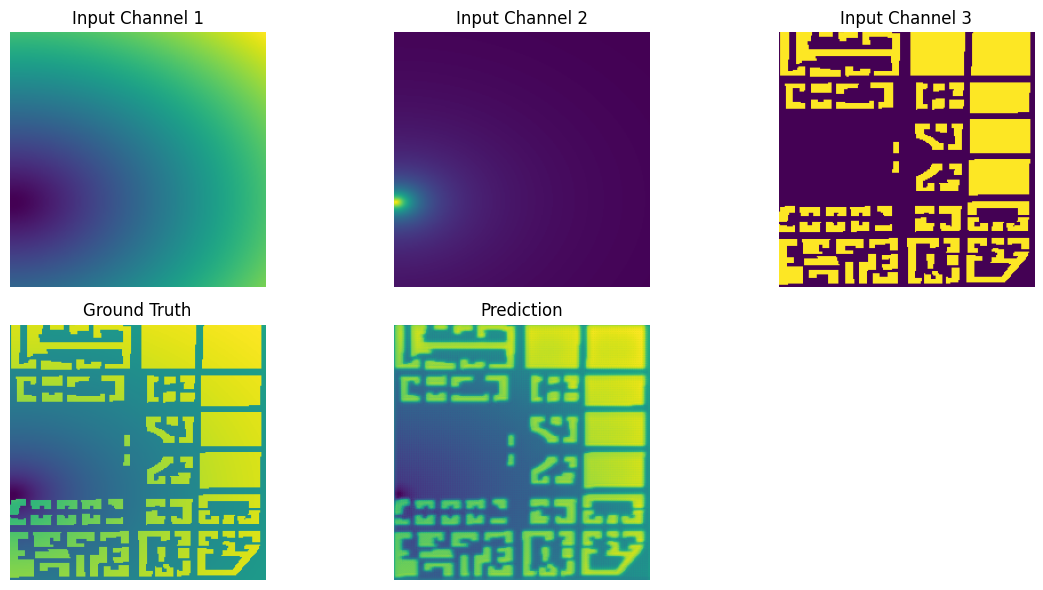

In [ ]:
# Step 1: Get one sample from the validation dataset
for inputs, ground_truth in val_dataset.take(1):  # Take one batch from validation dataset
    sample_input = inputs[0]  # Take the first sample from the batch
    sample_ground_truth = ground_truth[0]  # Corresponding ground truth
    break

# Step 2: Run the model prediction
sample_prediction = trained_model.predict(np.expand_dims(sample_input, axis=0))[0]

# Step 3: Plot results side-by-side
def plot_side_by_side(input_image, ground_truth, prediction):
    plt.figure(figsize=(12, 6))

    # Plot input channels
    for i in range(input_image.shape[-1]):  # Loop through 3 channels
        plt.subplot(2, input_image.shape[-1], i + 1)
        plt.imshow(input_image[:, :, i], cmap='viridis')
        plt.title(f"Input Channel {i+1}")
        plt.axis("off")

    # Plot ground truth
    plt.subplot(2, input_image.shape[-1], input_image.shape[-1] + 1)
    plt.imshow(ground_truth, cmap='viridis')
    plt.title("Ground Truth")
    plt.axis("off")

    # Plot prediction
    plt.subplot(2, input_image.shape[-1], input_image.shape[-1] + 2)
    plt.imshow(prediction, cmap='viridis')
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Step 4: Call the function to visualize
plot_side_by_side(sample_input, sample_ground_truth, sample_prediction)


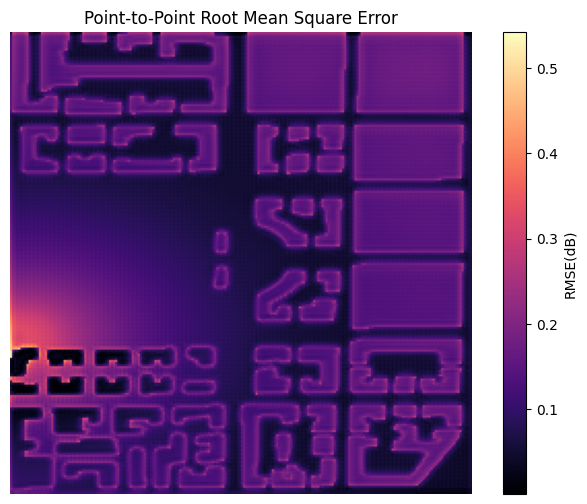

In [ ]:
def plot_mean_absolute_difference(ground_truth, prediction):
    # Step 1: Compute the Mean Absolute Difference
    mad = np.sqrt(np.square(ground_truth - prediction))

    # Step 2: Plot the MAD
    plt.figure(figsize=(8, 6))
    im = plt.imshow(mad, cmap='magma')  # Using 'magma' colormap for better contrast
    plt.title("Point-to-Point Root Mean Square Error")
    plt.colorbar(im, label="RMSE(dB)")
    plt.axis("off")
    plt.show()

# Call the function to plot MAD
plot_mean_absolute_difference(sample_ground_truth, sample_prediction)


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/projects/UNET_PL_Prediction/data/trained_models/dist_phi_building_model/my_model.h5')

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/projects/UNET_PL_Prediction/data/trained_models/dist_phi_building_model/my_model.h5', custom_objects={'my_custom_loss':my_custom_loss, 'my_custom_mae':my_custom_mae})

In [ ]:
trained_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_4… │
├──────────────────────

 Total params: 8,642,275 (32.97 MB)

 Trainable params: 8,636,385 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 2 (12.00 B)